

# ♻️ AI Waste Segregation System 🗑️ - represented by Eco Thinkers
This project focuses on building a real-time AI-based waste classification system that can automatically identify different types of waste using a machine learning model. The main objective is to promote efficient waste segregation to support recycling and reduce environmental pollution.

We trained a Convolutional Neural Network (CNN) model using the TensorFlow/Keras framework to classify images into six waste categories: **battery**, **glass**,**metal**, **organic**, **paper**, and **plastic**. The dataset was sourced from a public repository on Kaggle.

## This notebook contains the full training pipeline, including:



*   Data loading and preprocessing
*   Data augmentation
*   CNN model design using MobileNetV2
*   Class imbalance handling
*   Model evaluation and metrics
*   Conversion to .tflite for real-time use


In [1]:
# 📦 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore", category=UserWarning)

c:\Users\patil\OneDrive\Desktop\1M2B\EcoClassify-Vision-main\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 📁 Dataset Setup
IMG_SIZE = 224
BATCH_SIZE = 32
data_dir = 'Garbage classification'

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True
)

# ✅ Training Generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# ✅ Validation Generator
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [3]:
print(train_gen.class_indices)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [4]:
# 📊 Class Weights
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weights_dict)

# 🧪 Custom Generator with Sample Weights
def weighted_generator(generator, class_weights_dict):
    while True:
        x_batch, y_batch = next(generator)
        sample_weights = np.array([class_weights_dict[int(label)] for label in y_batch])
        yield x_batch, y_batch, sample_weights

train_gen_with_weights = weighted_generator(train_gen, class_weights_dict)

Class Weights: {np.int32(0): np.float64(1.04437564499484), np.int32(1): np.float64(0.8412302576891105), np.int32(2): np.float64(1.0284552845528456), np.int32(3): np.float64(0.7086834733893558), np.int32(4): np.float64(0.8739205526770294), np.int32(5): np.float64(3.066666666666667)}


In [5]:
# 🧠 Transfer Learning Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ❄️ Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# 🔓 Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ⚙️ Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 🛑 Callbacks
early = EarlyStopping(patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only=True)

# 🚀 Training
steps_per_epoch = len(train_gen)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 1,691,142 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [6]:
history = model.fit(
    train_gen_with_weights,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early, checkpoint]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 896ms/step - accuracy: 0.2609 - loss: 1.7244 - val_accuracy: 0.3539 - val_loss: 1.5758
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.4896 - loss: 1.3689 - val_accuracy: 0.4553 - val_loss: 1.4167
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.5929 - loss: 1.1779 - val_accuracy: 0.4891 - val_loss: 1.3610
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - accuracy: 0.6576 - loss: 1.0234 - val_accuracy: 0.5209 - val_loss: 1.3112
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.7085 - loss: 0.8949 - val_accuracy: 0.5129 - val_loss: 1.2627
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 462ms/step - accuracy: 0.7490 - loss: 0.8136 - val_accuracy: 0.5586 - val_loss: 1.2041
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.7302 - loss: 0.7632 - val_accuracy: 0.5686 - val_loss: 1.1318
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 462ms/step - accuracy: 0.7856 - loss: 0.6705 - val_accu

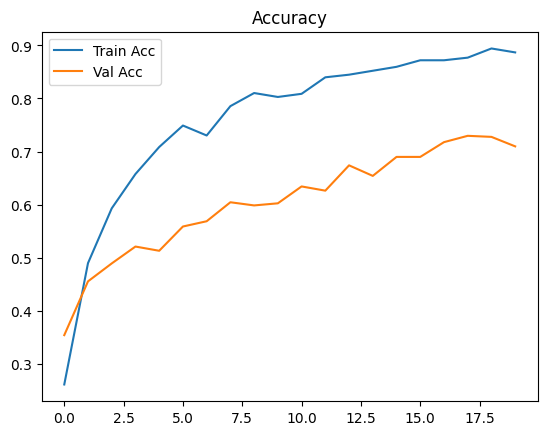

In [7]:
# 📈 5. Performance Visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [8]:
# Save as .keras
model.save('models/waste_model.keras')

# Load from .keras
model = keras.models.load_model('models/waste_model.keras', compile=False)


In [9]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save .tflite
with open("models/waste_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\patil\AppData\Local\Temp\tmpxi2t28rc\assets


INFO:tensorflow:Assets written to: C:\Users\patil\AppData\Local\Temp\tmpxi2t28rc\assets


Saved artifact at 'C:\Users\patil\AppData\Local\Temp\tmpxi2t28rc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1952361695184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361699792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361699600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361703632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361699984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361704016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361708240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361708048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361708432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1952361703824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  195236

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.92      0.61      0.74        80
       glass       0.67      0.76      0.71       100
       metal       0.90      0.67      0.77        82
       paper       0.79      0.88      0.83       118
     plastic       0.59      0.71      0.64        96
       trash       0.48      0.52      0.50        27

    accuracy                           0.73       503
   macro avg       0.73      0.69      0.70       503
weighted avg       0.75      0.73      0.73       503



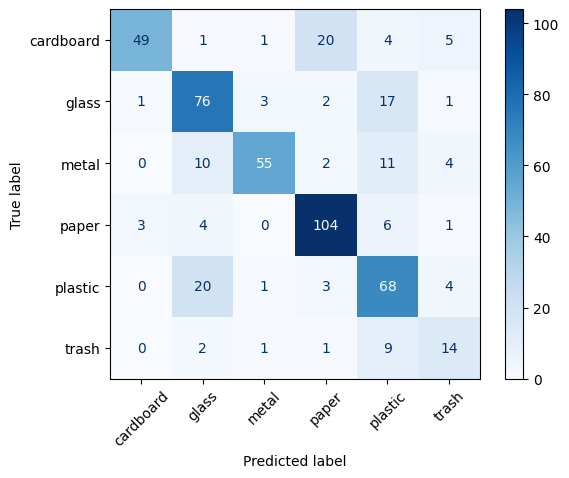

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# ✅ Load model (if not already loaded)
model = load_model('models/waste_model.keras')

# ✅ Predict on validation set
val_gen.reset()  # Ensures correct label order
Y_true = val_gen.classes
Y_pred = model.predict(val_gen, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# ✅ Class labels
class_labels = list(val_gen.class_indices.keys())

# 📋 Print classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# ✅ Optional: Show confusion matrix as well
cm = confusion_matrix(Y_true, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)




---
 # Thank You...



---


